![logo](../../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Satellite cloud cover for Climate modelling

Production date: 15-10-2024, modified 29-04-2025, finalized 01-02-2026

Produced by: CNRS

## 🌍 Use case: Detection of changes in the latitudinal position of cloudiest and clearest regions

## ❓ Quality assessment question:

- __Which of the C3S satellite datasets provides the smallest uncertainty and biases in cloud fraction?__

Clouds are fundamental regulators of the Earth's climate system, significantly influencing the planet's radiative budget, hydrological cycle, and global circulation. These factors, in turn, play a crucial role in shaping ecosystems, agriculture, water resources, and weather patterns. The overall impact of clouds on Earth's climate is determined by various properties, including cloud cover, height, thickness, and microphysical characteristics. Given their substantial influence on climate, cloud properties are extensively studied, both in the present context and in relation to their evolution under climate change.
The following notebook focuses on the cloud cover, which strongly impacts the Earth's climate. A large cloud cover can lead to increased albedo, reflecting more sunlight back into space, which can cool the surface. Conversely, a small cloud cover may result in enhanced solar radiation reaching the Earth's surface, leading to higher temperatures and altered precipitation patterns.

This analysis utilizes cloud observations from the dataset [__Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations__](https://cds.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview), available at the Climate Data Store. Two complementary Thematic Climate Data Records of cloud properties are provided from two families: CLARA (CM SAF cLoud, Albedo and surface Radiation) and CCI (Climate Change Initiative). These data differ in temporal and horizontal resolution as well as in applied retrieval methods. _Recently, the retrieval version CLARA-A2 has been replaced by CLARA-A3._ CLARA cloud products are derived from AVHRR (Advanced Very High Resolution Radiometer) observations. The CCI cloud products, derived from ATSR2 (Along Track Scanning Radiometer) and AATSR (Advanced ATSR) measurements, only cover the period 1995-2012. A CCI intermediate climate data record is available from 2017 onwards, using SLSTR (Sea and Land Surface Temperature Radiometer). The latter is not yet homogenized with the earlier data. Therefore, it is not used in this analysis.

CLARA and CCI use different methods to retrieve cloud cover. This notebook presents a comparative analysis of their cloud cover estimates, both among themselves and against other satellite data [[1]](https://doi.org/10.1007/s10712-024-09824-0). Additionally, it includes a discussion on the comparisons and uncertainty estimates.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note

- CLARA-A3's global mean cloud cover is 63.5%, falling within the range of the recently updated GEWEX cloud assessment (66% ± 4%), whereas CCI's global mean cloud cover of 59.3% lies outside this range.

- The latitudinal behaviour of cloud cover is consistent between CLARA and CCI, within the large uncertainty range of CCI. Though in polar regions during winter the CLARA-A3 cloud cover is slightly improved compared to CLARA-A2, it has still a negative bias compared to active lidar, which is better suited for cloud detection above snow and ice surfaces.

- The cloud cover uncertainty of CLARA-A3 varies between 5 to 10%, with largest values in the polar regions, while the one of CCI varies between 10 to 15%, with largest values in the subtropics.

- Geographical patterns show large cloud cover near the equator, in the midlatitudes over ocean, as well as in the stratocumulus regions off the western coasts in the subtropics. Prominent regions with low cloud cover are over the deserts and the subtropical ocean, in particular where one expects open cell cumulus clouds. However, the CCI patterns are much noisier than the ones from CLARA.

- Compared to CLARA-A2, the CLARA-A3 cloud cover is larger over ocean, in particular at larger latitudes, and smaller over land. This leads to a slightly larger global mean difference in cloud cover between ocean and land than the one given by CLARA-A2 in the updated GEWEX cloud assessment of about 15.5%, which lies in the range of the mean over all datasets (15% ± 5%), but is slightly larger than the one from CALIPSO (14%).
```

## 📋 Methodology

The analysis comprises the following steps:

**[](satellite_satellite-cloud-properties_uncertainty-quality-flags_q01:section:parameters)**

- Import the relevant libraries. Define the parameters of the analysis and set the dataset requests.

**[](satellite_satellite-cloud-properties_uncertainty-quality-flags_q01:section:download)**

- Download CLARA-A3, CLARA-A2 and CCI monthly mean cloud cover and associated uncertainty, for eight years over the common period 2005-2012, over the whole globe.
- Filter out months with low-quality status for CLARA-A3.

**[](satellite_satellite-cloud-properties_uncertainty-quality-flags_q01:section:results)**

- Compute the zonal means of cloud cover and its uncertainty across all latitudes
- Plot the latitudinal annual mean cloud cover and uncertainty
- Plot the latitudinal cloud cover during boreal winter and summer
- Plot the latitudinal cloud cover difference between boreal summer and winter
- Plot the global maps of annual mean cloud cover of the three datasets
- Plot the global maps of annual mean cloud cover difference of CCI and CLARA-A2 with CLARA-A3

## 📈 Analysis and results

(satellite_satellite-cloud-properties_uncertainty-quality-flags_q01:section:parameters)=
### Choose the parameters to use and setup code

This section includes the library imports and the parameter settings for the analysis.

#### Import packages

In [2]:
import collections
import os

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
from c3s_eqc_automatic_quality_control import download, plot

plt.style.use("seaborn-v0_8-notebook")

#### Define parameters

In [9]:
# Time range
start = "2004-05"
stop = "2012-04"

#### Set the data request

In [10]:
collection_id = "satellite-cloud-properties"

request_cci = {
    "product_family": "cci",
    "time_aggregation": "monthly_mean",
    "climate_data_record_type": "thematic_climate_data_record",
    "sensor_on_satellite": "aatsr_on_envisat",
    "variable": "all_variables",
    "origin": "esa",
}

request_clara = {
    "origin": "eumetsat",
    "variable": ["cloud_fraction"],
    "climate_data_record_type": "thematic_climate_data_record",
    "time_aggregation": "monthly_mean",
}


requests = collections.defaultdict(list)
for date in pd.date_range(start, stop, freq="1MS"):
    time_request = {"year": date.strftime("%Y"), "month": date.strftime("%m")}
    requests["CCI"].append(request_cci | time_request)
    requests["CLARA-A2"].append(
        request_clara | {"product_family": "clara_a2"} | time_request
    )
    requests["CLARA-A3"].append(
        request_clara | {"product_family": "clara_a3"} | time_request
    )
requests = dict(requests)

(satellite_satellite-cloud-properties_uncertainty-quality-flags_q01:section:download)=
### Download the datasets

In this section, three monthly datasets are downloaded. The CCI files lack "time" information within the xarray coordinates; therefore, the time information is extracted from the file attributes.

In addition, the CLARA-A3 product provides a quality flag labeled "record_status" which indicates the overall status of each month. This flag indicates the quality of the data, and any month identified as low quality is subsequently filtered out.

The three datasets are standardized to ensure uniformity in format. 

In [11]:
def preprocess(ds):
    time = pd.to_datetime(ds.attrs["time_coverage_start"].replace("Z", ""))
    return ds.assign_coords(time=[time])


def zonal_mean(ds):
    return ds.mean("longitude", keep_attrs=True)


def time_mean(ds, remove_bad_values):
    if remove_bad_values:
        ds = ds.where(ds["record_status"] == 0)
    return ds.mean("time", keep_attrs=True)


def standardise(ds, product):
    if product == "CCI":
        # Cloud fraction in the CCI product is multiplied by 100,
        # so that it is coherent with the CLARA products
        ds["cfc"] = ds["cfc"] * 100
        ds["cfc_unc"] = ds["cfc_unc"] * 100

    if product == "CLARA-A3":
        # Standardize the name of the uncertainty estimate in the datasets
        ds = ds.rename(cfc_unc_mean="cfc_unc")

    ds["cfc"].attrs = {"long_name": "Cloud cover", "units": "%"}
    return ds


datasets_zonal = {}
datasets_maps = {}
for product, request in requests.items():
    print(f"{product=}")
    ds = download.download_and_transform(
        collection_id,
        request,
        preprocess=preprocess,
        transform_func=zonal_mean,
        transform_chunks=False,
    )
    datasets_zonal[product] = standardise(ds, product)

    ds = download.download_and_transform(
        collection_id,
        request,
        preprocess=preprocess,
        transform_chunks=False,
        transform_func=time_mean,
        transform_func_kwargs={"remove_bad_values": product == "CLARA-A3"},
    )
    datasets_maps[product] = standardise(ds, product)

product='CCI'


100%|██████████| 96/96 [00:03<00:00, 27.91it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  return xr.open_mfdataset(
100%|██████████| 96/96 [00:01<00:00, 49.31it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults

product='CLARA-A2'


100%|██████████| 96/96 [00:02<00:00, 37.29it/s] 
                                     

product='CLARA-A3'


100%|██████████| 96/96 [00:01<00:00, 55.39it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/cacholote/extra_encoders.py:297: SerializationWarning: cannot serialize global coordinates {'lat_bnds'} because the global attribute 'coordinates' already exists. This may prevent faithful roundtrippingof xarray datasets
  obj.to_netcdf(tmpfilename)
100%|██████████| 96/96 [00:03<00:00, 30.34it/s] 
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/cacholote/extra_encoders.py:297: SerializationWarning: cannot serialize global coordinates {'lon_bnds', 'lat_bnds'} because the global attribute 'coordinates' already exists. This may prevent faithful roundtrippingof xarray datasets
  obj.to_netcdf(tmpfilename)


#### Filter out CLARA-A3 low-quality status

For the CLARA-A3 product, the "record_status" for each month can have the following values: 0 for "ok", 1 for "void", and 2 for "bad_quality". Records marked with "bad_quality" must be filtered out; however, all months have good quality.

In [12]:
mask = datasets_zonal["CLARA-A3"]["record_status"] == 0
print(f"Number of bad quality data: {(~mask).sum().values}")

# Filter-out low quality data
datasets_zonal["CLARA-A3"] = datasets_zonal["CLARA-A3"].where(mask.compute(), drop=True)

Number of bad quality data: 0


_Quality flag "record_status" for each month of the CLARA-A3 data. The values can have the following values: 0 for "ok", 1 for "void", and 2 for "bad_quality"._

(satellite_satellite-cloud-properties_uncertainty-quality-flags_q01:section:results)=
### Results

In this section, cloud amounts and their associated uncertainty estimates are averaged and presented as a function of latitude. The function "plot_latitudinal_cloud_fraction" is defined, which is later utilized to visualize the latitudinal cloud cover for various data selections: across an entire year, during the summer season, and during the winter season.

In [13]:
def plot_latitudinal_cloud_fraction(ds, ax, product):
    ds = ds.mean(set(ds.dims) - {"latitude"}, keep_attrs=True)

    colors = {
        "CCI": "dodgerblue",
        "CLARA-A2": "orange",
        "CLARA-A3": "red",
    }
    da = ds["cfc"]
    ax.fill_between(
        ds["latitude"],
        da - ds.get("cfc_unc", 0),
        da + ds.get("cfc_unc", 0),
        color=colors[product],
        alpha=0.3,
    )
    ax.plot(ds["latitude"], da, color=colors[product], label=product)
    ax.legend(frameon=False)
    ax.set_xlabel("Latitude [degrees]")
    ax.set_ylabel(f"{da.long_name} [{da.units}]")

#### Latitudinal behaviour of cloud cover

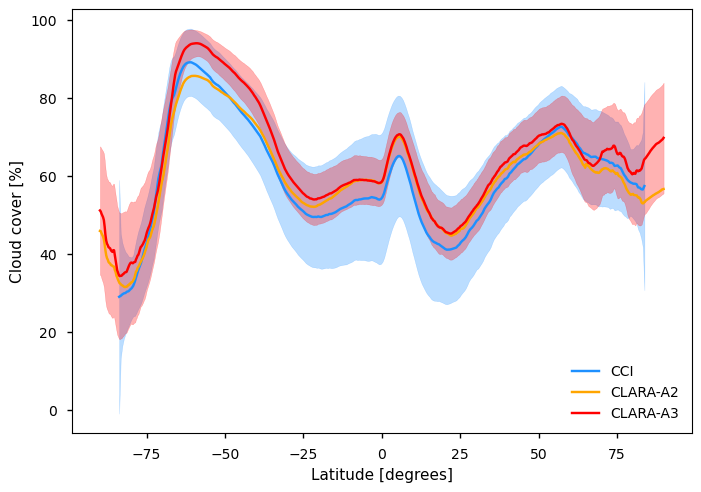

In [14]:
fig, ax = plt.subplots()
for product, ds in datasets_zonal.items():
    plot_latitudinal_cloud_fraction(ds, ax, product)

_Figure 1: Latitudinal behaviour of annual mean cloud cover for the datasets CCI, CLARA-A2, and CLARA-A3, with the averages calculated for the period 2004-2012. The solid line represents the annual means, while the shaded area indicates the average uncertainty across each latitudinal band. Uncertainty estimates are available for CCI and CLARA-A3._

The latitudinal behaviour of the annual mean cloud cover is visualized in Figure 1, using the monthly mean datasets of CCI, CLARA-A2, and CLARA-A3. The shaded areas represent the zonal annual mean uncertainty. The plot reveals several key features worth highlighting.

The CCI zonal annual mean uncertainties (10 to 15%) are much larger than the ones of CLARA-A3 (5 to 10%), while CLARA-A2 does not provide any estimate of uncertainties.

The latitudinal behaviour of the three datasets is similar, with CLARA-A3 providing the largest cloud cover. Still all the three products agree within the uncertainty of CCI. The latitudinal cloud cover behaviour is also similar to the ones of the 11 datasets reported in the most recent GEWEX Cloud Assessment [[1]](https://doi.org/10.1007/s10712-024-09824-0).

The peaks and troughs in latitudinal cloud cover are influenced by global atmospheric circulation. The largest cloud cover is observed in the mid-latitudes, driven by mid and low clouds in the summer and storm clouds in the winter. The narrow peak in the deep tropics corresponds to the Intertropical Convergence Zone, which is associated with heavy precipitation. The troughs are linked to the subsidence regions in the subtropics and Antarctica.

#### Seasonal variation of zonal mean cloud cover

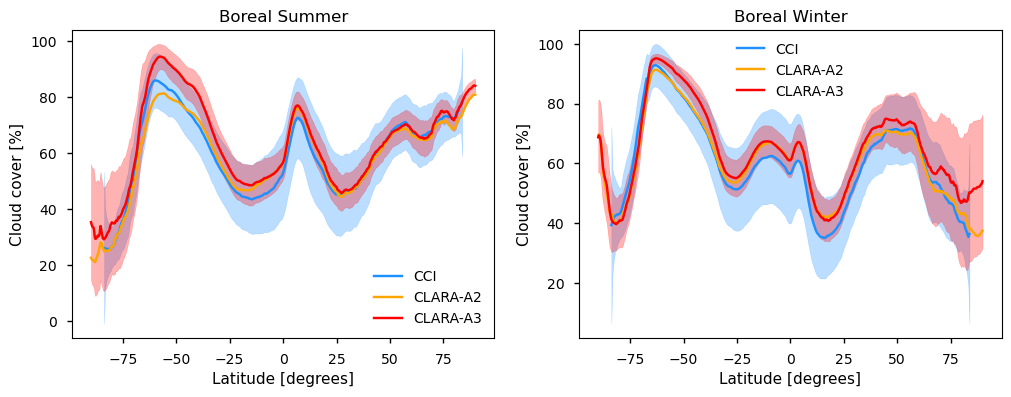

In [15]:
seasons = {"JJA": "Boreal Summer", "DJF": "Boreal Winter"}
fig, axs = plt.subplots(1, len(seasons), figsize=(12, 4))
for product, ds in datasets_zonal.items():
    for season, ds_season in ds.groupby("time.season"):
        if season not in seasons:
            continue
        ax = axs[list(seasons).index(season)]
        plot_latitudinal_cloud_fraction(ds_season, ax, product)
        ax.set_title(seasons[season])

_Figure 2: Latitudinal behaviour of mean cloud cover for the datasets CCI, CLARA-A2, and CLARA-A3, separately for boreal Summer (left) and Winter (right). The solid lines represent the zonal means, while the shaded areas indicate the average uncertainties across each latitudinal band._

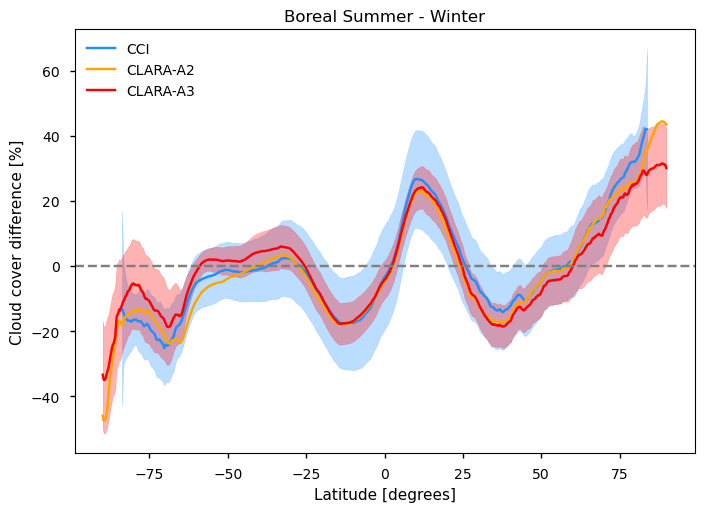

In [16]:
fig, ax = plt.subplots()
for product, ds in datasets_zonal.items():
    ds = ds.groupby("time.season").mean().sel(season=["DJF", "JJA"])
    ds_diff = ds[["cfc"]].diff("season").squeeze("season")
    if "cfc_unc" in ds:
        ds_diff = ds_diff.merge(ds["cfc_unc"].mean("season"))
    ds_diff["cfc"].attrs = {"long_name": "Cloud cover difference", "units": "%"}
    plot_latitudinal_cloud_fraction(ds_diff, ax, product)
ax.axhline(0, color="gray", ls="--")
_ = ax.set_title("Boreal Summer - Winter")

_Figure 3: Seasonal difference (Boreal Summer and Winter) of zonal mean cloud cover from CCI, CLARA-A2, and CLARA-A3. The solid line represents the zonal mean difference, while the shaded area indicates the average uncertainty across each latitudinal band._

According to Figures 2 and 3, the datasets again agree in their latitudinal behaviour in both seasons.

At polar latitudes, the CLARA-A3 uncertainties are largest during winter: The lack of illumination reduces the ability to fully exploit all AVHRR channels. Twilight conditions present further challenges due to solar contamination effect. During polar summer, under continuous illumination, the uncertainties are much smaller.

The difference between boreal summer and winter clearly shows the displacement of the ITCZ towards the summer hemisphere in all three datasets. Furthermore, more clouds are detected in polar summer than in polar winter. In general, these seasonal differences are aligned with the ones of the datasets in the recently updated GEWEX cloud assessment, except for CALIPSO (Cloud-Aerosol Lidar and Infrared Pathfinder Satellite Observation) in the polar winter [[1]](https://doi.org/10.1007/s10712-024-09824-0). The latter active instrument is more sensitive to clouds over ice and snow than passive remote sensing, in particular during nighttime [[2]](https://acp.copernicus.org/articles/10/1789/2010/).

The CCI uncertainty shows less variation, probably because the data are given at a single observation time (10h local time), except a large increase at both latitude edges, probably linked to a decreasing accuracy of measurements near the swath edges.

#### Global maps

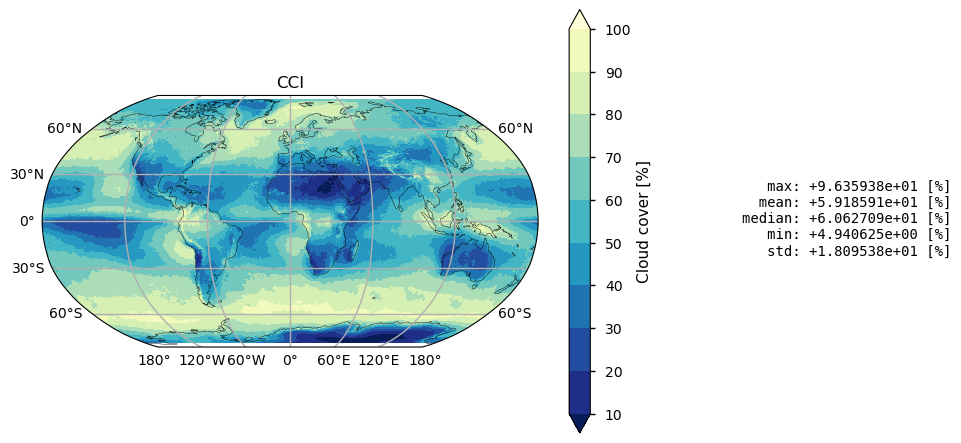

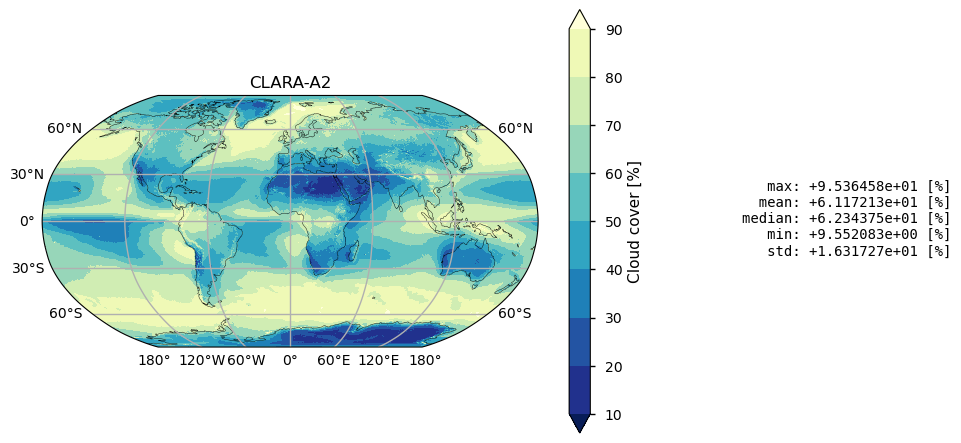

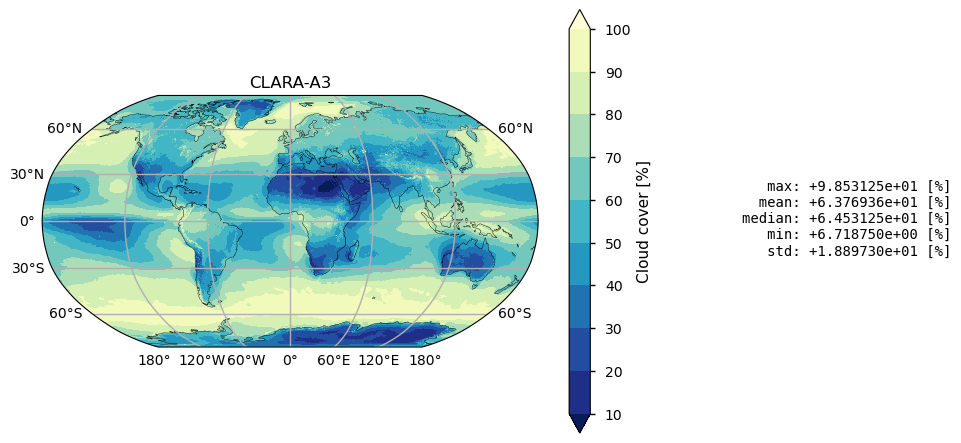

In [17]:
for product, ds in datasets_maps.items():
    plot.projected_map(
        ds["cfc"],
        projection=ccrs.Robinson(),
        cmap="YlGnBu_r",
        levels=9,
        robust=True,
        extend="both",
    )
    plt.title(product)
    plt.show()

_Figure 4: Geographical maps of annual mean cloud cover from CCI (top), CLARA-A2 (middle), and CLARA-A3 (bottom), calculated over the period 2004-2012._

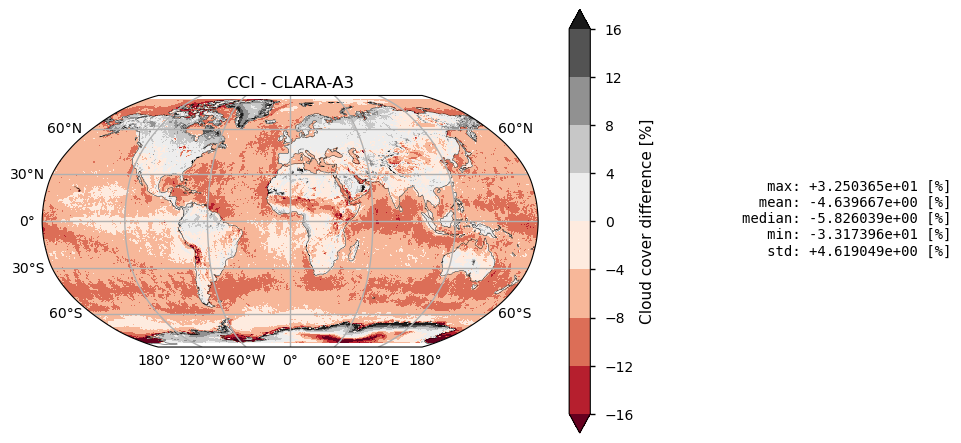

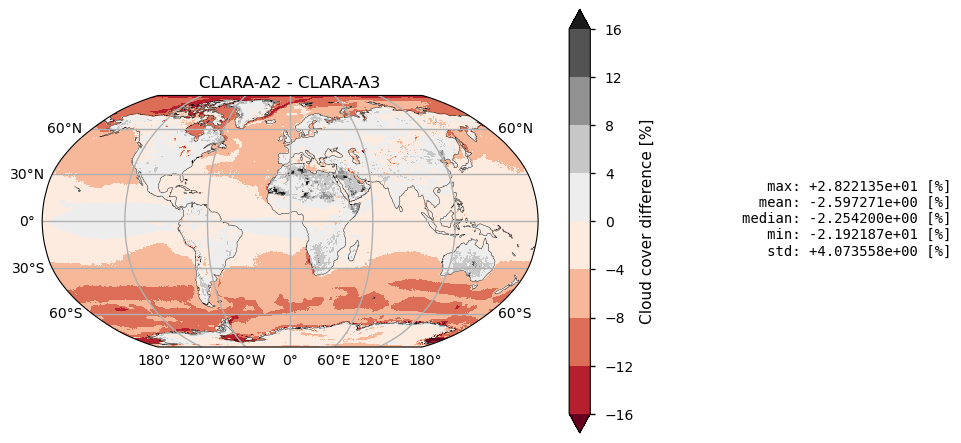

In [19]:
da_clara_a3 = datasets_maps["CLARA-A3"]["cfc"].coarsen(latitude=2, longitude=2).mean()
for product, ds in datasets_maps.items():
    if product == "CLARA-A3":
        continue
    if product.startswith("CLARA"):
        ds = ds.coarsen(latitude=2, longitude=2).mean()
    da = ds["cfc"] - da_clara_a3
    da.attrs = {"long_name": "Cloud cover difference", "units": "%"}
    plot.projected_map(
        da,
        projection=ccrs.Robinson(),
        cmap="RdGy",
        levels=9,
        robust=True,
        extend="both",
    )
    plt.title(f"{product} - CLARA-A3")
    plt.show()

_Figure 5: Cloud cover difference maps between CCI (top) and CLARA-A2 (bottom) and CLARA-A3, calculated for the period 2004-2012. The differences are computed at a spatial resolution of 0.5 degrees._

According to Figure 4, global means between the three datasets vary from 59.3% (CCI) to 63.5% (CLARA-A3). The latter one is within the range of the global mean of the recently updated GEWEX cloud assessment, given as 66% ± 4%.
The geographical patterns of large cloud cover show prominent features near the equator as the Inter-Tropical Convergence Zone (ITCZ), in the midlatitudes over ocean, in particular in the Southern hemisphere, given by winter storm tracks and stratocumulus and the stratocumulus regions off the western coasts in the subtropics. Prominent regions with low cloud cover are over the deserts and the subtropical ocean, in particular where one expects open cell cumulus clouds.
However, the CCI patterns are much noisier than the ones from CLARA. This can be seen in the map differences in Figure 5.
    The difference between CLARA-A3 and CLARA-A2 is positive over ocean, in particular at larger latitudes, and negative over land. This leads to a slightly larger global mean cloud cover difference between ocean and land than the one given by CLARA-A2 (15.5%) and which lies within the range of the one estimated by the updated GEWEX cloud assessment of about 15% ± 5%.

## ℹ️ If you want to know more

### Key resources

Some key resources and further reading are linked throughout this assessment.

The CDS catalogue entry for the data used is:

- Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations:
  https://cds.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview

Code libraries used:

- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [B-Open](https://www.bopen.eu/)

The GEWEX Cloud Assessment:

- The Global Energy and Water Exchanges (GEWEX) program is a core project of the World Climate Research Programme (WCRP). The first GEWEX Cloud Assessment was published in 2012 and it provided the first coordinated inter-comparison of publicly available, global
  cloud products \[[3](https://doi.org/10.1175/BAMS-D-12-00117.1)-[4](https://www.wcrp-climate.org/documents/GEWEX_Cloud_Assessment_2012.pdf)\]. The database associated with the GEWEX Cloud Assessment
  has revealed its usefulness for the assessment of new datasets. Since in the last decade existing
  cloud property retrievals have been revised and new retrievals have been developed, this exercise has been recently repeated with 11 global cloud products derived from measurements of multi-spectral imagers, IR sounders, and lidar [[1]](https://doi.org/10.1007/s10712-024-09824-0). The first cloud assessment included products from ATSR, while the most recent assessment includes CLARA-A2. However, the CLARA-A2 version (V2.1) in the CDS is a later version than the one provided in the updated GEWEX cloud assessment (V2.0), and therefore slightly improved. The updated cloud assessment database is available at [this link](https://gewexca.aeris-data.fr/).

### Reference/Useful material

[[1]](https://doi.org/10.1007/s10712-024-09824-0) Stubenrauch, C.J., Kinne, S., Mandorli, G. et al. Lessons Learned from the Updated GEWEX Cloud Assessment Database. Surv Geophys (2024). https://doi.org/10.1007/s10712-024-09824-0

[[2]](https://acp.copernicus.org/articles/10/1789/2010/) Karlsson, K.-G. and Dybbroe, A.: Evaluation of Arctic cloud products from the EUMETSAT Climate Monitoring Satellite Application Facility based on CALIPSO-CALIOP observations, Atmos. Chem. Phys., 10, 1789–1807, https://doi.org/10.5194/acp-10-1789-2010, 2010.

[[3]](https://doi.org/10.1175/BAMS-D-12-00117.1) Stubenrauch, C. J., and Coauthors, 2013: Assessment of Global Cloud Datasets from Satellites: Project and Database Initiated by the GEWEX Radiation Panel. Bull. Amer. Meteor. Soc., 94, 1031–1049, https://doi.org/10.1175/BAMS-D-12-00117.1

[[4]](https://www.wcrp-climate.org/documents/GEWEX_Cloud_Assessment_2012.pdf) Stubenrauch CJ, Rossow WB, Kinne S, GEWEX Cloud Assessment Team (2012) Assessment of Global Cloud Datasets from Satellites, A Project of the World Climate Research Programme Global Energy and Water Cycle Experiment (GEWEX) Radiation Panel, WCRP report.